In [1]:
import numpy as np
import pandas as pd

pd.options.display.float_format = '{:20,.4f}'.format

In [2]:
#import returns and size file

tna = pd.read_csv('mret_tna.csv',parse_dates=['caldt'],na_values=['R','T'])
tna = tna[tna['mtna'] >= 0]
tna = tna[tna['mret'] > -1]


In [3]:
#To observe all values present in the dataset
#tna['mret'].value_counts().sort_index()

#To identify a string in the mtna column
#[item for item in set(tna['mtna'].value_counts().index) if item.isalpha()]

In [4]:
tna[['mtna','mret']].describe()

###HOW DO I DESCRIBE MULTIPLE COLUMNS? HOW DO I SUPRESS SCIENTIFIC NOTATION?

,mtna,mret
count,"4,720,137.0000","4,720,137.0000"
mean,538.2051,0.0050
std,"3,118.5113",0.0413
min,0.0000,-0.9802
25%,4.9000,-0.0074
50%,36.5000,0.0042
75%,210.4000,0.0213
max,"306,670.6000",10.8966


In [5]:
#import mf characteristics file 

mf_char = pd.read_csv('fund_char.csv',parse_dates=['caldt'])
mf_char = mf_char.dropna(subset=['crsp_cl_grp'])
mf_char['crsp_cl_grp'] = mf_char['crsp_cl_grp'].astype(np.int64)
mf_char.head()

,summary_period2,crsp_fundno,caldt,per_cash,crsp_portno,crsp_cl_grp,ncusip,exp_ratio,crsp_obj_cd
0,AQ,105,2004-12-31,nan,"1,000,880.0000",2000026,028837102,0.0285,EF
1,AQ,105,2005-12-30,0.0000,"1,000,880.0000",2000026,028837102,0.0272,EF
2,AQ,105,2006-12-29,0.0000,"1,000,880.0000",2000026,028837102,0.0258,EF
3,AQ,105,2007-12-31,0.0000,"1,000,880.0000",2000026,028837102,0.0259,EF
4,AQ,105,2008-12-31,0.8400,"1,000,880.0000",2000026,028837102,0.0256,EF


In [6]:
#drop extra columns not needed for analysis

mf_char2 = mf_char.drop(['summary_period2','ncusip','crsp_portno'], axis=1)
mf_char2.head()

,crsp_fundno,caldt,per_cash,crsp_cl_grp,exp_ratio,crsp_obj_cd
0,105,2004-12-31,nan,2000026,0.0285,EF
1,105,2005-12-30,0.0000,2000026,0.0272,EF
2,105,2006-12-29,0.0000,2000026,0.0258,EF
3,105,2007-12-31,0.0000,2000026,0.0259,EF
4,105,2008-12-31,0.8400,2000026,0.0256,EF


In [7]:
#create ym variables for analysis at month level
tna['ym'] = pd.to_datetime(tna['caldt']).dt.to_period('M')
tna_ym = tna.drop('caldt', axis=1)
tna_ym.head()

,crsp_fundno,mtna,mret,ym
48,105,51.5000,0.0361,2004-01
49,105,51.5000,-0.0028,2004-02
50,105,52.1000,-0.0038,2004-03
51,105,49.7000,-0.0483,2004-04
52,105,50.5000,0.0249,2004-05


In [8]:
mf_char2['ym'] = pd.to_datetime(mf_char2['caldt']).dt.to_period('M')
mf_ym = mf_char2
mf_ym.head()

,crsp_fundno,caldt,per_cash,crsp_cl_grp,exp_ratio,crsp_obj_cd,ym
0,105,2004-12-31,nan,2000026,0.0285,EF,2004-12
1,105,2005-12-30,0.0000,2000026,0.0272,EF,2005-12
2,105,2006-12-29,0.0000,2000026,0.0258,EF,2006-12
3,105,2007-12-31,0.0000,2000026,0.0259,EF,2007-12
4,105,2008-12-31,0.8400,2000026,0.0256,EF,2008-12


In [9]:
#merge tna_ym and mf_ym by fundno & ym - how = inner (ie. must have data in both sets)
tna_ret = pd.merge(tna_ym,mf_ym,on=['crsp_fundno','ym'],how='inner')

tna_ret['mret']
tna_ret.head()

,crsp_fundno,mtna,mret,ym,caldt,per_cash,crsp_cl_grp,exp_ratio,crsp_obj_cd
0,105,52.4000,0.0318,2004-12,2004-12-31,nan,2000026,0.0285,EF
1,105,51.5000,0.0146,2005-12,2005-12-30,0.0000,2000026,0.0272,EF
2,105,57.3000,0.0134,2006-12,2006-12-29,0.0000,2000026,0.0258,EF
3,105,57.9000,-0.0042,2007-12,2007-12-31,0.0000,2000026,0.0259,EF
4,105,25.5000,0.0607,2008-12,2008-12-31,0.8400,2000026,0.0256,EF


In [10]:
#clean NaN values for cash and exp ratio, forward fill objective codes by crsp_cl_grp
tna_ret2 = tna_ret.copy()
tna_ret2['per_cash'].fillna(0, inplace=True)
tna_ret2['exp_ratio'].fillna(0, inplace=True)
tna_ret2.sort_values(['crsp_cl_grp','ym'],inplace=True)

tna_ret2['obj'] = tna_ret2.groupby('crsp_cl_grp')['crsp_obj_cd'].fillna(method='ffill')
tna_ret2.drop('crsp_obj_cd', axis=1, inplace=True)
#tna_ret2['obj'] = tna_ret2.groupby('crsp_cl_grp')['crsp_obj_cd'].apply(lambda x: x.ffill())

tna_ret2.head(10)

,crsp_fundno,mtna,mret,ym,caldt,per_cash,crsp_cl_grp,exp_ratio,obj
0,105,52.4000,0.0318,2004-12,2004-12-31,0.0000,2000026,0.0285,EF
279641,45769,2.3000,0.0327,2004-12,2004-12-31,0.0000,2000026,0.0000,EF
1,105,51.5000,0.0146,2005-12,2005-12-30,0.0000,2000026,0.0272,EF
279642,45769,4.1000,0.0088,2005-12,2005-12-30,0.0000,2000026,0.0172,EF
2,105,57.3000,0.0134,2006-12,2006-12-29,0.0000,2000026,0.0258,EF
279643,45769,4.8000,0.0144,2006-12,2006-12-29,0.0000,2000026,0.0158,EF
3,105,57.9000,-0.0042,2007-12,2007-12-31,0.0000,2000026,0.0259,EF
279644,45769,4.9000,-0.0038,2007-12,2007-12-31,0.0000,2000026,0.0159,EF
4,105,25.5000,0.0607,2008-12,2008-12-31,0.8400,2000026,0.0256,EF
279645,45769,2.3000,0.0611,2008-12,2008-12-31,0.8400,2000026,0.0156,EF


In [11]:
#calculate portfolio tna
portno_size = tna_ret2.groupby(['crsp_cl_grp','ym'],as_index=False).agg({'mtna':'sum'})
portno_size.rename(columns={'mtna':'portno_tna'},inplace=True) #update tna_portno in place or replace the file
portno_size.head()

,crsp_cl_grp,ym,portno_tna
0,2000026,2004-12,54.7000
1,2000026,2005-12,55.6000
2,2000026,2006-12,62.1000
3,2000026,2007-12,62.8000
4,2000026,2008-12,27.8000


In [12]:
#merge portfolio tna with fundno data to allow for weight calculations
port1 = pd.merge(tna_ret2,portno_size,on=['crsp_cl_grp','ym'],how='inner')
port1.head()


,crsp_fundno,mtna,mret,ym,caldt,per_cash,crsp_cl_grp,exp_ratio,obj,portno_tna
0,105,52.4000,0.0318,2004-12,2004-12-31,0.0000,2000026,0.0285,EF,54.7000
1,45769,2.3000,0.0327,2004-12,2004-12-31,0.0000,2000026,0.0000,EF,54.7000
2,105,51.5000,0.0146,2005-12,2005-12-30,0.0000,2000026,0.0272,EF,55.6000
3,45769,4.1000,0.0088,2005-12,2005-12-30,0.0000,2000026,0.0172,EF,55.6000
4,105,57.3000,0.0134,2006-12,2006-12-29,0.0000,2000026,0.0258,EF,62.1000


In [13]:
#calculate weights and weight * vars
port1['wgt'] = port1['mtna'] / port1['portno_tna']
port1['port_cash'] = port1['per_cash'] * port1['wgt']
port1['port_exp'] = port1['exp_ratio'] * port1['wgt']
port1['port_ret'] = port1['mret'] * port1['wgt']
port1.head()

,crsp_fundno,mtna,mret,ym,caldt,per_cash,crsp_cl_grp,exp_ratio,obj,portno_tna,wgt,port_cash,port_exp,port_ret
0,105,52.4000,0.0318,2004-12,2004-12-31,0.0000,2000026,0.0285,EF,54.7000,0.9580,0.0000,0.0273,0.0305
1,45769,2.3000,0.0327,2004-12,2004-12-31,0.0000,2000026,0.0000,EF,54.7000,0.0420,0.0000,0.0000,0.0014
2,105,51.5000,0.0146,2005-12,2005-12-30,0.0000,2000026,0.0272,EF,55.6000,0.9263,0.0000,0.0252,0.0135
3,45769,4.1000,0.0088,2005-12,2005-12-30,0.0000,2000026,0.0172,EF,55.6000,0.0737,0.0000,0.0013,0.0006
4,105,57.3000,0.0134,2006-12,2006-12-29,0.0000,2000026,0.0258,EF,62.1000,0.9227,0.0000,0.0238,0.0123


In [14]:
port2 = port1.groupby(['crsp_cl_grp','ym'],as_index=False).agg({'port_cash':'sum','port_exp':'sum','port_ret':'sum'})
port2.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret
0,2000026,2004-12,0.0000,0.0273,0.0319
1,2000026,2005-12,0.0000,0.0265,0.0141
2,2000026,2006-12,0.0000,0.0250,0.0135
3,2000026,2007-12,0.0000,0.0251,-0.0041
4,2000026,2008-12,0.8400,0.0248,0.0607


In [15]:
#merge portfolio weight vars with original file to keep crsp_obj_cd
port3 = port1[['crsp_cl_grp','ym','obj','portno_tna']]
port4 = port3.groupby(['crsp_cl_grp','ym']).cumcount()==0
port5 = port3[port4]

port6 = pd.merge(port2,port5,on=['crsp_cl_grp','ym'],how='inner')
port6.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret,obj,portno_tna
0,2000026,2004-12,0.0000,0.0273,0.0319,EF,54.7000
1,2000026,2005-12,0.0000,0.0265,0.0141,EF,55.6000
2,2000026,2006-12,0.0000,0.0250,0.0135,EF,62.1000
3,2000026,2007-12,0.0000,0.0251,-0.0041,EF,62.8000
4,2000026,2008-12,0.8400,0.0248,0.0607,EF,27.8000


In [16]:
#calculate object level performance
obj1 = port6.groupby(['obj','ym'],as_index=False).agg({'portno_tna':'sum'})
obj1.rename(columns={'portno_tna':'obj_tna'},inplace=True)
obj1.head()

,obj,ym,obj_tna
0,EDCI,2004-12,"14,922.8000"
1,EDCI,2005-12,"14,428.4000"
2,EDCI,2006-12,"16,657.6000"
3,EDCI,2007-12,"14,580.6000"
4,EDCI,2008-12,"7,014.5000"


In [17]:
#merge objective tna with portfolio data to allow for weight calculations
obj2 = pd.merge(port6,obj1,on=['obj','ym'],how='inner')
obj2.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret,obj,portno_tna,obj_tna
0,2000026,2004-12,0.0000,0.0273,0.0319,EF,54.7000,"525,629.9000"
1,2000271,2004-12,0.0000,0.0076,0.0431,EF,677.5000,"525,629.9000"
2,2000476,2004-12,31.5500,0.0232,0.0098,EF,70.7000,"525,629.9000"
3,2000486,2004-12,7.8600,0.0207,0.0396,EF,289.7000,"525,629.9000"
4,2000500,2004-12,6.5600,0.0253,0.0426,EF,22.3000,"525,629.9000"


In [18]:
#calculate weights and weight * vars
obj2['obj_wgt'] = obj2['portno_tna'] / obj2['obj_tna']
obj2['obj_wgt_ret'] = obj2['port_ret'] * obj2['obj_wgt']
obj2.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret,obj,portno_tna,obj_tna,obj_wgt,obj_wgt_ret
0,2000026,2004-12,0.0000,0.0273,0.0319,EF,54.7000,"525,629.9000",0.0001,0.0000
1,2000271,2004-12,0.0000,0.0076,0.0431,EF,677.5000,"525,629.9000",0.0013,0.0001
2,2000476,2004-12,31.5500,0.0232,0.0098,EF,70.7000,"525,629.9000",0.0001,0.0000
3,2000486,2004-12,7.8600,0.0207,0.0396,EF,289.7000,"525,629.9000",0.0006,0.0000
4,2000500,2004-12,6.5600,0.0253,0.0426,EF,22.3000,"525,629.9000",0.0000,0.0000


In [19]:
obj3 = obj2.groupby(['obj','ym'],as_index=False).agg({'obj_wgt_ret':'sum'})
obj3.rename(columns={'obj_wgt_ret':'obj_ret'},inplace=True)

obj3['lag_obj_ret'] = obj3.groupby('obj')['obj_ret'].shift()
obj3.dropna(subset=['lag_obj_ret'],inplace=True)

obj3.head()

,obj,ym,obj_ret,lag_obj_ret
1,EDCI,2005-12,0.0042,0.0450
2,EDCI,2006-12,0.0109,0.0042
3,EDCI,2007-12,-0.0009,0.0109
4,EDCI,2008-12,0.0509,-0.0009
5,EDCI,2009-12,0.0761,0.0509


In [20]:
obj4 = pd.merge(obj2,obj3,on=['obj','ym'],how='left')
obj4 = obj4.drop(['obj_wgt','obj_wgt_ret'], axis=1)
obj4.dropna(subset=['lag_obj_ret'],inplace=True)
obj4.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret,obj,portno_tna,obj_tna,obj_ret,lag_obj_ret
406,2000026,2005-12,0.0000,0.0265,0.0141,EF,55.6000,"681,732.9000",0.0451,0.0400
407,2000271,2005-12,0.4400,0.0078,0.0551,EF,259.0000,"681,732.9000",0.0451,0.0400
408,2000476,2005-12,9.4491,0.0225,0.0184,EF,170.1000,"681,732.9000",0.0451,0.0400
409,2000486,2005-12,0.0000,0.0202,0.0307,EF,435.4000,"681,732.9000",0.0451,0.0400
410,2000500,2005-12,5.6400,0.0248,0.0333,EF,32.7000,"681,732.9000",0.0451,0.0400


In [21]:
#calculate fund flows as [tna(t) - [tna(t-1) * 1+port_ret] ]/ portno_tna(t-1)
flow = obj4.copy()
flow.sort_values(['crsp_cl_grp','ym'],inplace=True)
flow['l_port_tna'] = flow.groupby('crsp_cl_grp')['portno_tna'].shift()
flow['flow'] = (flow['portno_tna'] - flow['l_port_tna'] * (1 + flow['port_ret'])) / flow['l_port_tna']
flow.dropna(subset=['flow'],inplace=True)

In [22]:
#retain only ED mutual funds
flow2 = flow.copy()

flow2['obj_2'] = flow2['obj'].str.slice(0,2)

#flow2['obj_2'] = flow2['obj'].astype(str).str[:2]
flow2 = flow2[flow2['obj_2'] == 'ED']

flow2.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret,obj,portno_tna,obj_tna,obj_ret,lag_obj_ret,l_port_tna,flow,obj_2
12239,2000035,2006-12,2.0600,0.0110,-0.0007,EDYG,433.5000,"1,418,682.1000",0.0046,0.0079,423.4000,0.0245,ED
12240,2000137,2006-12,0.0000,0.0124,-0.0087,EDYG,423.1000,"1,418,682.1000",0.0046,0.0079,414.8000,0.0288,ED
38199,2000137,2007-12,0.0000,0.0111,0.0054,EDYG,489.7000,"1,634,767.9000",-0.0033,0.0046,423.1000,0.1520,ED
39379,2000137,2008-12,3.9000,0.0111,0.0249,EDYG,245.8000,"1,114,048.0000",0.0237,-0.0033,489.7000,-0.5230,ED
40980,2000137,2009-12,0.4900,0.0101,0.0213,EDYG,229.8000,"1,444,846.4000",0.0319,0.0237,245.8000,-0.0864,ED


In [23]:
#create 1-month lagged returns (portno)

flow2.sort_values(['crsp_cl_grp','ym'],inplace=True)
flow2['lag_ret'] = flow2.groupby('crsp_cl_grp')['port_ret'].shift()
flow2.dropna(subset=['lag_ret'],inplace=True)

flow2.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret,obj,portno_tna,obj_tna,obj_ret,lag_obj_ret,l_port_tna,flow,obj_2,lag_ret
38199,2000137,2007-12,0.0000,0.0111,0.0054,EDYG,489.7000,"1,634,767.9000",-0.0033,0.0046,423.1000,0.1520,ED,-0.0087
39379,2000137,2008-12,3.9000,0.0111,0.0249,EDYG,245.8000,"1,114,048.0000",0.0237,-0.0033,489.7000,-0.5230,ED,0.0054
40980,2000137,2009-12,0.4900,0.0101,0.0213,EDYG,229.8000,"1,444,846.4000",0.0319,0.0237,245.8000,-0.0864,ED,0.0249
38200,2000234,2007-12,-0.1200,0.0066,-0.0165,EDYG,841.1000,"1,634,767.9000",-0.0033,0.0046,676.5000,0.2598,ED,0.0168
39380,2000234,2008-12,2.7300,0.0083,0.0375,EDYG,312.1000,"1,114,048.0000",0.0237,-0.0033,841.1000,-0.6664,ED,-0.0165


In [24]:
#create descriptive tables and figures

#general descriptive statistics of variables

flow2 = flow2[flow2['flow'] < 1]
flow2 = flow2[flow2['flow'] > -1]
flow2 = flow2[flow2['port_ret'] < 1]
    
flow2.describe()

,crsp_cl_grp,port_cash,port_exp,port_ret,portno_tna,obj_tna,obj_ret,lag_obj_ret,l_port_tna,flow,lag_ret
count,"38,776.0000","38,776.0000","38,776.0000","38,776.0000","38,776.0000","38,776.0000","38,776.0000","38,776.0000","38,776.0000","38,776.0000","38,776.0000"
mean,"2,008,990.1047",5.3480,-0.7671,0.0128,"1,630.0216","1,091,393.3883",0.0131,0.0136,"1,522.4763",0.0382,0.0136
std,"6,078.4792",21.4333,7.8565,0.0362,"9,192.0570","870,940.3211",0.0282,0.0296,"7,929.2329",0.3276,0.0385
min,"2,000,137.0000",-525.1100,-99.0000,-0.5965,0.1000,"2,308.4000",-0.1690,-0.1690,0.1000,-0.9980,-0.6925
25%,"2,004,532.0000",0.0500,0.0025,-0.0052,58.4000,"340,856.4000",-0.0043,-0.0050,60.6000,-0.1409,-0.0055
50%,"2,008,481.0000",1.1700,0.0092,0.0113,238.8000,"788,998.1000",0.0114,0.0114,241.0500,0.0215,0.0123
75%,"2,012,519.2500",3.5700,0.0124,0.0283,922.5000,"1,905,474.0000",0.0237,0.0270,901.1000,0.2138,0.0299
max,"2,061,747.0000",410.0700,0.7267,0.4565,"662,577.0000","2,573,961.4000",0.1884,0.1884,"498,117.1000",0.9996,1.3818


In [25]:
#correlation of variables
flow2.corr()

,crsp_cl_grp,port_cash,port_exp,port_ret,portno_tna,obj_tna,obj_ret,lag_obj_ret,l_port_tna,flow,lag_ret
crsp_cl_grp,1.0000,0.0566,-0.0245,-0.1068,-0.0401,0.0710,-0.1223,-0.1090,-0.0473,0.1074,-0.0928
port_cash,0.0566,1.0000,0.0147,-0.1499,-0.0308,-0.1595,-0.1325,-0.1689,-0.0324,-0.0506,-0.1616
port_exp,-0.0245,0.0147,1.0000,0.0123,-0.0239,-0.0987,0.0069,0.0035,-0.0225,-0.0440,0.0101
port_ret,-0.1068,-0.1499,0.0123,1.0000,-0.0078,-0.0891,0.7906,0.1377,-0.0140,0.0470,0.1239
portno_tna,-0.0401,-0.0308,-0.0239,-0.0078,1.0000,0.0510,-0.0121,-0.0099,0.9832,0.0475,-0.0073
obj_tna,0.0710,-0.1595,-0.0987,-0.0891,0.0510,1.0000,-0.1041,-0.0893,0.0498,0.1202,-0.0749
obj_ret,-0.1223,-0.1325,0.0069,0.7906,-0.0121,-0.1041,1.0000,0.1492,-0.0190,0.0636,0.1267
lag_obj_ret,-0.1090,-0.1689,0.0035,0.1377,-0.0099,-0.0893,0.1492,1.0000,-0.0146,0.0805,0.7562
l_port_tna,-0.0473,-0.0324,-0.0225,-0.0140,0.9832,0.0498,-0.0190,-0.0146,1.0000,0.0131,-0.0113
flow,0.1074,-0.0506,-0.0440,0.0470,0.0475,0.1202,0.0636,0.0805,0.0131,1.0000,0.0657


C:\Users\jrstark\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Portfolio Rets')

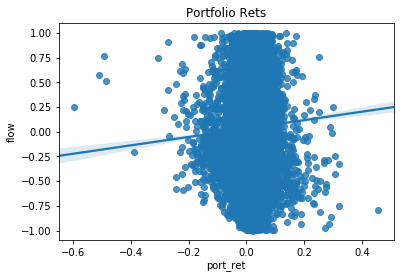

In [26]:
#graph relation between flow and (1) port_ret (2) lag_ret (3) obj_ret (4) lag_obj_ret (5) size
import seaborn as sns
%matplotlib inline

sns.regplot(x='port_ret',y='flow',data=flow2).set_title('Portfolio Rets')

Text(0.5, 1.0, 'Lag Rets')

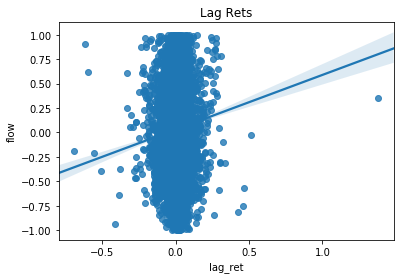

In [27]:
sns.regplot(x='lag_ret',y='flow',data=flow2).set_title('Lag Rets')

Text(0.5, 1.0, 'Obj Rets')

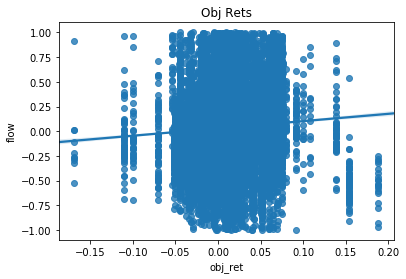

In [28]:
sns.regplot(x='obj_ret',y='flow',data=flow2).set_title('Obj Rets')

Text(0.5, 1.0, 'Lag Obj Rets')

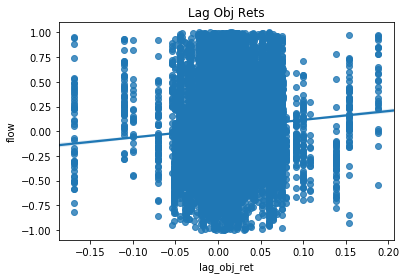

In [29]:
sns.regplot(x='lag_obj_ret',y='flow',data=flow2).set_title('Lag Obj Rets')

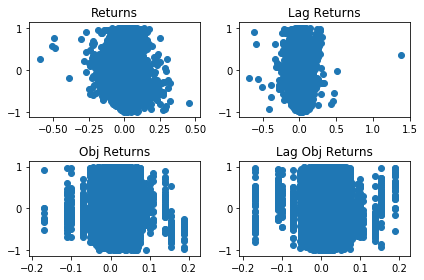

In [30]:
import matplotlib.pyplot as plt

plt.subplot(2,2,1)
plt.scatter(x='port_ret',y='flow',data=flow2)
plt.title('Returns')
plt.subplot(2,2,2)
plt.scatter(x='lag_ret',y='flow',data=flow2)
plt.title('Lag Returns')
plt.subplot(2,2,3)
plt.scatter(x='obj_ret',y='flow',data=flow2)
plt.title('Obj Returns')
plt.subplot(2,2,4)
plt.scatter(x='lag_obj_ret',y='flow',data=flow2)
plt.title('Lag Obj Returns')

plt.tight_layout()
plt.show()

In [31]:
#RANKS AND AVERAGE FLOW

flow3 = flow2.copy()
flow3['ranks'] = flow3.groupby('ym')['port_ret'].transform(pd.qcut, 10, labels=False)
#flow3.groupby(['ranks']).agg({'port_ret':'mean'})
flow3.groupby(['ranks']).agg({'flow':'mean'})

,flow
ranks,
0.0000,-0.0374
1.0000,0.0237
2.0000,0.0372
3.0000,0.0441
4.0000,0.0564
5.0000,0.0650
6.0000,0.0667
7.0000,0.0560
8.0000,0.0549


In [36]:
### 1 - rolling windows

flow2['movit'] = flow2.groupby('crsp_cl_grp')['flow'].rolling(3).mean().reset_index(0,drop=True)
flow2

#flow3['mov_avg']=flow3.groupby('crsp_cl_grp').rolling(window=3,min_periods=3,on='flow',center=False).mean().reset_index()
#flow3.head()

,crsp_cl_grp,ym,port_cash,port_exp,port_ret,obj,portno_tna,obj_tna,obj_ret,lag_obj_ret,l_port_tna,flow,obj_2,lag_ret,movit
38199,2000137,2007-12,0.0000,0.0111,0.0054,EDYG,489.7000,"1,634,767.9000",-0.0033,0.0046,423.1000,0.1520,ED,-0.0087,nan
39379,2000137,2008-12,3.9000,0.0111,0.0249,EDYG,245.8000,"1,114,048.0000",0.0237,-0.0033,489.7000,-0.5230,ED,0.0054,nan
40980,2000137,2009-12,0.4900,0.0101,0.0213,EDYG,229.8000,"1,444,846.4000",0.0319,0.0237,245.8000,-0.0864,ED,0.0249,-0.1525
38200,2000234,2007-12,-0.1200,0.0066,-0.0165,EDYG,841.1000,"1,634,767.9000",-0.0033,0.0046,676.5000,0.2598,ED,0.0168,nan
39380,2000234,2008-12,2.7300,0.0083,0.0375,EDYG,312.1000,"1,114,048.0000",0.0237,-0.0033,841.1000,-0.6664,ED,-0.0165,nan
40981,2000234,2009-12,2.0800,0.0079,0.0331,EDYG,379.8000,"1,444,846.4000",0.0319,0.0237,312.1000,0.1838,ED,0.0375,-0.0743
58920,2000234,2010-12,2.2300,0.0075,0.0646,EDYG,393.5000,"1,611,927.2000",0.0598,0.0319,379.8000,-0.0285,ED,0.0331,-0.1704
60467,2000234,2011-12,0.1000,0.0067,-0.0058,EDYG,735.5000,"1,514,056.9000",-0.0052,0.0598,393.5000,0.8749,ED,0.0646,0.3434
62021,2000234,2012-12,0.0000,0.0058,0.0133,EDYG,732.3000,"1,633,805.5000",0.0102,-0.0052,735.5000,-0.0176,ED,-0.0058,0.2763
63481,2000234,2013-12,0.0000,0.0060,0.0241,EDYG,833.7000,"2,166,943.2000",0.0270,0.0102,732.3000,0.1144,ED,0.0133,0.3239


In [ ]:
flow3.head(40)


The results up to this point indicate that investors observe positive performance in mutual funds and invest in those funds. They also observe mutual fund objectives that outperform and invest in those funds as well. This is consistent with investors trying to move money into outperforming mutual funds.
